In [3]:
import numpy as np
import matplotlib.pyplot as plt
import utils
import os
%matplotlib inline

import tensorflow as tf
print("Tensorflow version:", tf.__version__)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
from livelossplot import PlotLossesKeras


Tensorflow version: 2.8.0


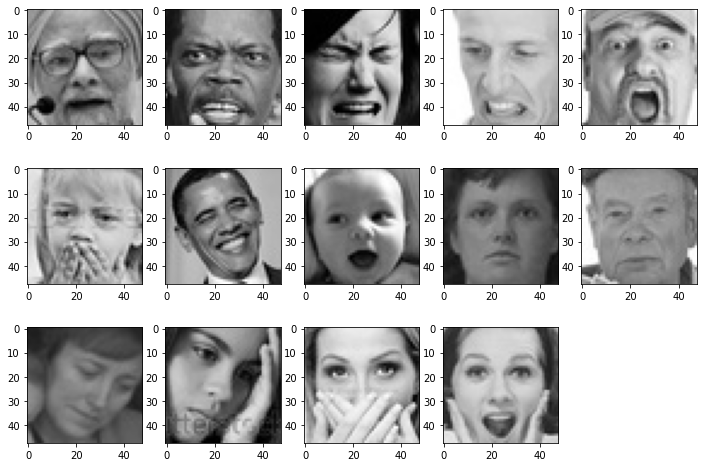

In [11]:
# First look at images

from keras.preprocessing.image import load_img, img_to_array

base_path = 'C:/Users/Brent/Documents/UNCC/DSBA_6165/Midterm1/'
counter = 0
image_size = 48
plt.figure(0, figsize=(12,20))

for expression in os.listdir(base_path + "train/"):
    for i in range(1,3):
        counter = counter + 1
        plt.subplot(7,5,counter)
        image = load_img(base_path + "train/" + expression + "/" +
                       os.listdir(base_path + "train/" + expression)[i], target_size=(image_size, image_size))
        plt.imshow(image, cmap="gray")

In [7]:
# Class counts

for expression in os.listdir("train/"):
    print(str(len(os.listdir("train/"+expression)))+ " " + expression + " images")

3993 angry images
436 disgust images
4103 fear images
7164 happy images
4982 neutral images
4938 sad images
3205 surprise images


In [10]:
# Image Generator

batch_size = 64
class_size = 7

datagen_train = ImageDataGenerator(horizontal_flip = True)
train_generator = datagen_train.flow_from_directory("train/",
                                                   target_size = (image_size, image_size),
                                                   color_mode = 'grayscale',
                                                   batch_size = batch_size,
                                                   class_mode = 'categorical',
                                                   shuffle = True)

datagen_valid = ImageDataGenerator(horizontal_flip = True)
valid_generator = datagen_train.flow_from_directory("valid/",
                                                   target_size = (image_size, image_size),
                                                   color_mode = 'grayscale',
                                                   batch_size = batch_size,
                                                   class_mode = 'categorical',
                                                   shuffle = True)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [12]:
# Model Design

model = Sequential()

#Layer 1
model.add(Conv2D(64, (3,3), padding = 'same', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Layer 2
model.add(Conv2D(256,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Layer 3
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Layer 4
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(class_size, activation='softmax'))

opt = Adam(learning_rate=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_6 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 256)      

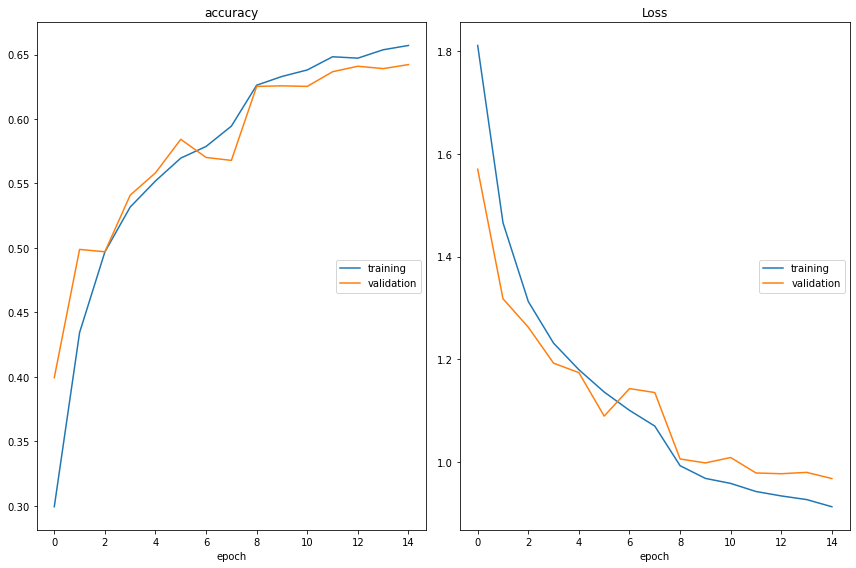

accuracy
	training         	 (min:    0.299, max:    0.657, cur:    0.657)
	validation       	 (min:    0.399, max:    0.642, cur:    0.642)
Loss
	training         	 (min:    0.912, max:    1.812, cur:    0.912)
	validation       	 (min:    0.967, max:    1.570, cur:    0.967)

Epoch 15: saving model to model_weights.h5
450/450 [==============================] - 803s 2s/step - loss: 0.9122 - accuracy: 0.6570 - val_loss: 0.9671 - val_accuracy: 0.6422 - lr: 5.0000e-05


In [14]:
# Train Model

from livelossplot.tf_keras import PlotLossesCallback
epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
valid_steps = valid_generator.n//valid_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', verbose=1, save_weights_only=True, mode='max')
reduce_learnrate = ReduceLROnPlateau(monitor = 'val_loss', factor=0.1, patience=2, min_lr = 0.00001, model = 'auto')
callbacks = [PlotLossesCallback(), checkpoint, reduce_learnrate]

history = model.fit(x = train_generator,
                   steps_per_epoch = steps_per_epoch,
                    epochs = epochs,
                    validation_data = valid_generator,
                    validation_steps = valid_steps,
                    callbacks=callbacks
                   )

In [15]:
# Save Model as json

model_json = model.to_json()
with open ("model.json", "w") as json_file:
    json_file.write(model_json)